In [8]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 

%matplotlib inline

101
None


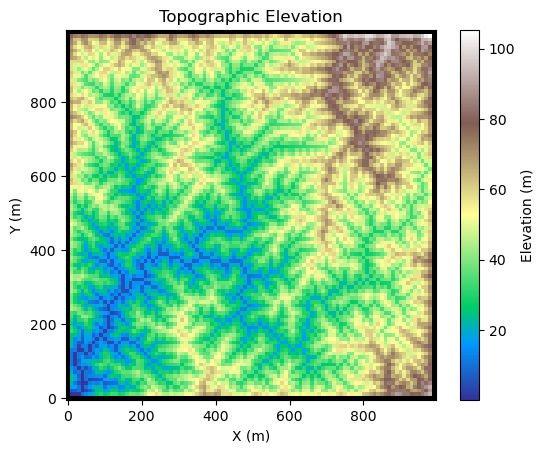

In [9]:
ncols = 100
nrows = 100
cellsize = 10

#mg = RasterModelGrid()
#Set directory paths to retrieve the asc file
#path_project = r"C:/Users/gsbir/Documents/EES_393/Export/" # add the path to the asc file    #this should access my H drive
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
#soil_dem = "sample_topo2_soil__depth.txt"
#bedrock_dem = "sample_topo2_bedrock__elevation.txt"
topo_path = topo_dem
#soil_path = path_project + soil_dem
#bedrock_path = path_project + bedrock_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
topo_header = read_asc_header(open(topo_path, 'r'))
#soil_header = read_asc_header(open(soil_path, 'r'))
#bedrock_header = read_asc_header(open(bedrock_path, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0)
#(mg, x) = read_esri_ascii(soil_path, name= 'soil__depth', halo = 1)
#(mg, y) = read_esri_ascii(bedrock_path, name= 'bedrock__elevation', halo = 1)

#set the watershed boundary condition and the function returns a integer which is the outlet_id so this is set equal to a variable so we can view this
#outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)


#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)#Close all model boundary edges


#find min elevation
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()

min_topo_ID = open_nodes[min_topo]

print(min_topo_ID)


#outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999.)
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id
outlet_id = min_topo_ID
#print(mg.at_node.keys()) #Shows the node attributes

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

#imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

add the rest of the fields 

In [10]:
#ADDING REST OF THE FIELDS
#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']
#mg.at_node["bedrock__elevation"][:] -= mg.at_node['soil__depth']

mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)


101


show the soil depth 
---- this should all be 2 m except for the outlet node which will be 0

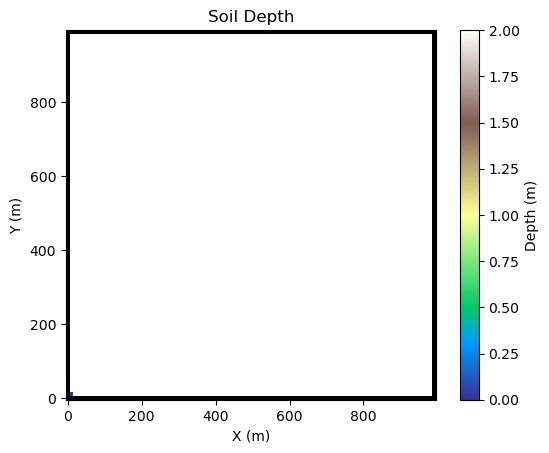

In [11]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'soil__depth', plot_name='Soil Depth', var_name = 'Depth', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

show the bedrock elevation

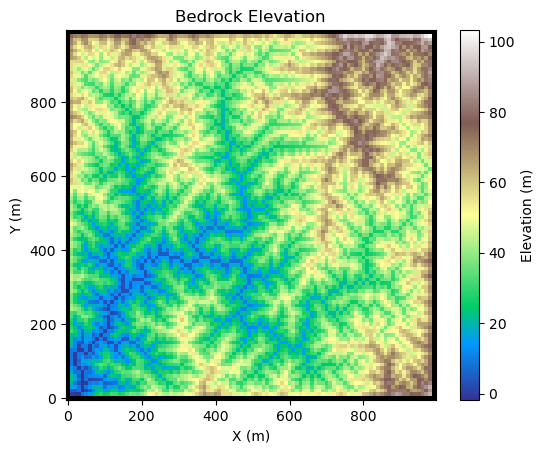

In [12]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'bedrock__elevation', plot_name='Bedrock Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

setting up SPACE

In [13]:
#SPACE PARAMETERS
#Set Model Time Parameters
timestep = 1.0
run_time = 100 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Parameters for SPACE and Fastscape
K_sed = 0.000001
K_sp = 0.00001
K_br = 0.000001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0


#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 

expweath = ExponentialWeatherer(mg)
DDdiff = DepthDependentDiffuser(mg, .0001)
expweath.calc_soil_prod_rate()
np.allclose(mg.at_node['soil_production__rate'][mg.core_nodes], .0001)


False

running space

runtime of 1000 range (just fr and sp) -> 1 min 35 sec
runtime of 1000 range (fr sp and dddiff) -> 1 min

In [14]:
for x in range(1000): 
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][mg.core_nodes]+= uplift_per_timestep  #adding uplift to the bedrock
    #mg.at_node["topographic__elevation"][outlet_id] -= 0.001 # Uplift
    
    fr.run_one_step()
    #fa.run_one_step()
    #df.map_depressions()
    sp.run_one_step(dt = timestep)
    DDdiff.run_one_step(1)
    print(x) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

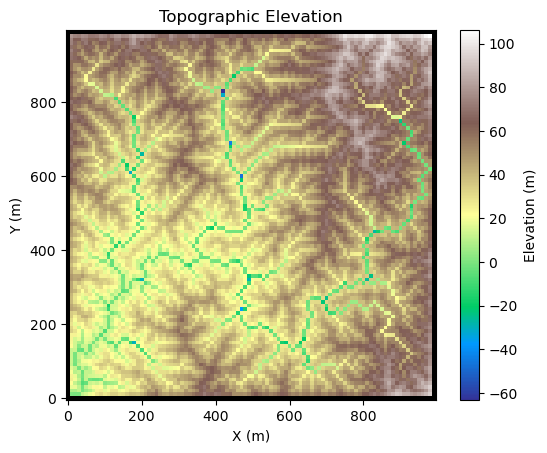

In [15]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)